In [ ]:
!pip install shap

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             brier_score_loss, precision_recall_curve)
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parents[2] / "src" / "python"))
from paths import training_path, models_path

In [4]:
df1 = pd.read_csv(training_path / "vcf_feature_vectors_hg38.csv")
df2 = pd.read_csv(training_path / "vcf_feature_vectors_seqc.csv")

df = pd.concat([df1, df2], ignore_index=True)

In [7]:
# df = pd.read_csv(training_path / "vcf_feature_vectors.csv")

non_features = ["CHROM", "POS", "REF", "ALT", "GOLDEN"]
features = df.drop(columns=non_features)
target = df["GOLDEN"]

In [8]:
number_of_features = len(features.columns)
print(f"Number of features {number_of_features}")

Number of features 19


In [9]:
mi_scores = mutual_info_classif(features, target, discrete_features=False, random_state=42)
mi_df = pd.DataFrame({
    "Feature": features.columns,
    "MI_Score": mi_scores
}).sort_values(by="MI_Score", ascending=False)

print("\nTop Features by Mutual Information with GOLDEN:")
print(mi_df)


Top Features by Mutual Information with GOLDEN:
     Feature  MI_Score
16  F1R2_alt  0.224482
18  F2R1_alt  0.224336
13    AD_alt  0.223547
14        AF  0.218863
9      NALOD  0.210373
11      TLOD  0.200918
10      NLOD  0.194304
1       ECNT  0.162247
7    MMQ_alt  0.146086
3    MBQ_alt  0.119180
8       MPOS  0.115753
5   MFRL_alt  0.104331
12    AD_ref  0.091499
17  F2R1_ref  0.084127
15  F1R2_ref  0.083741
6    MMQ_ref  0.078271
0         DP  0.064212
2    MBQ_ref  0.059839
4   MFRL_ref  0.057530


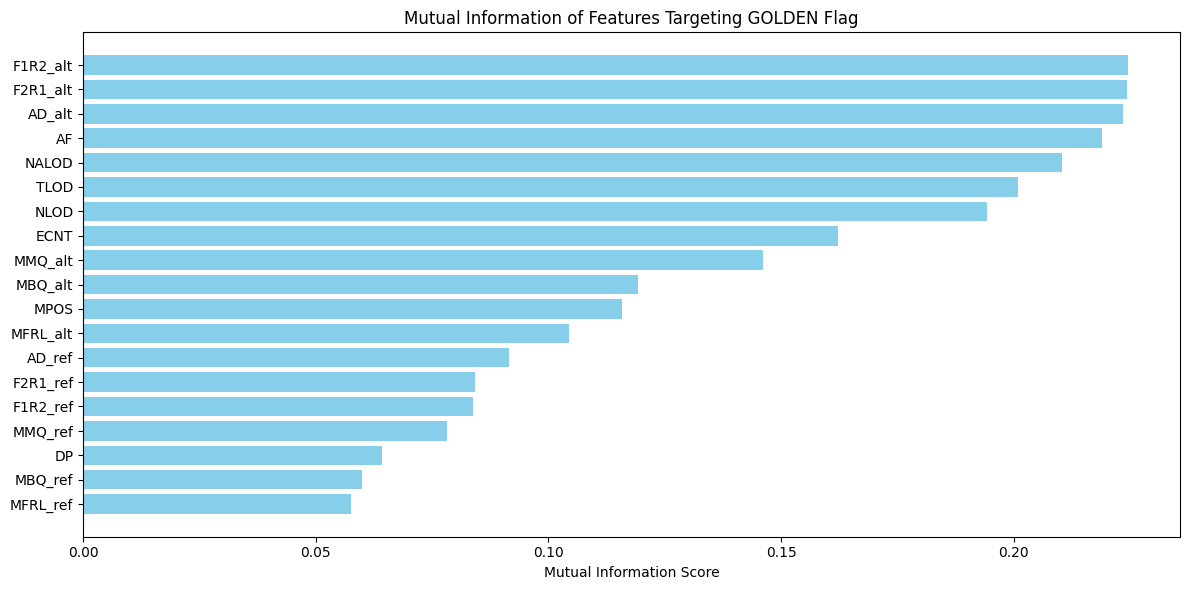

In [10]:
plt.figure(figsize=(12, 6))
plt.barh(mi_df["Feature"], mi_df["MI_Score"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Mutual Information of Features Targeting GOLDEN Flag")
plt.xlabel("Mutual Information Score")
plt.tight_layout()
plt.show()

In [11]:
features_to_keep = 9

In [12]:
# Either keep N number of top features or use them all
top_features = mi_df["Feature"].head(features_to_keep).tolist()
X = df[top_features]
y = target

In [13]:
# Stratified K-Fold + SHAP per test fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
shap_values_all = []
X_test_all = []
best_thresholds = []
metrics_list = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = lgb.LGBMClassifier(random_state=42)
    model.fit(X_train, y_train)

    # SHAP explanation
    explainer = shap.Explainer(model)
    shap_values_fold = explainer(X_test)
    shap_values_all.append(shap_values_fold.values)
    X_test_all.append(X_test)

    # Threshold tuning
    y_proba = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    best_thresholds.append(best_thresh)

    # Apply optimal threshold
    y_pred = (y_proba >= best_thresh).astype(int)

    # Metrics
    metrics = {
        "Fold": fold+1,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Average Precision (PR AUC)": average_precision_score(y_test, y_proba),
        "Brier Score": brier_score_loss(y_test, y_proba),
        "Best Threshold": best_thresh
    }
    metrics_list.append(metrics)

[LightGBM] [Info] Number of positive: 31887, number of negative: 243043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1909
[LightGBM] [Info] Number of data points in the train set: 274930, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115982 -> initscore=-2.031040
[LightGBM] [Info] Start training from score -2.031040
[LightGBM] [Info] Number of positive: 31887, number of negative: 243043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 274930, number of used features: 9
[LightGBM] [Info

In [14]:
metrics_df = pd.DataFrame(metrics_list)
print("\n Cross-Validation Hotspot Matrix:")
print(metrics_df)

print("\n Mean Metrics Across Folds:")
print(metrics_df.mean(numeric_only=True))


 Cross-Validation Hotspot Matrix:
   Fold  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0     1  0.992493   0.960133  0.975790  0.967898  0.998739   
1     2  0.992405   0.955156  0.980557  0.967690  0.998535   
2     3  0.992507   0.959231  0.976919  0.967995  0.998526   
3     4  0.992653   0.964998  0.971898  0.968436  0.998699   
4     5  0.992711   0.966646  0.970647  0.968642  0.998801   

   Average Precision (PR AUC)  Brier Score  Best Threshold  
0                    0.985250     0.006096        0.504557  
1                    0.983335     0.006219        0.437248  
2                    0.982894     0.006236        0.495829  
3                    0.985573     0.006195        0.600829  
4                    0.986517     0.006031        0.597991  

 Mean Metrics Across Folds:
Fold                          3.000000
Accuracy                      0.992554
Precision                     0.961233
Recall                        0.975162
F1 Score                      0.968132
RO

In [15]:
# Average best threshold across folds
avg_best_thresh = float(np.mean(best_thresholds))
print(f"✅ Average best threshold: {avg_best_thresh:.4f}")

✅ Average best threshold: 0.5273


In [16]:
# Retrain final model on full data
final_model = lgb.LGBMClassifier(random_state=42)
final_model.fit(X, y)
print("✅ Final model trained on full dataset.")

[LightGBM] [Info] Number of positive: 39859, number of negative: 303804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1858
[LightGBM] [Info] Number of data points in the train set: 343663, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115983 -> initscore=-2.031035
[LightGBM] [Info] Start training from score -2.031035
✅ Final model trained on full dataset.


In [17]:
# Save model and metadata
joblib.dump(final_model, models_path / "lightgbm_variant_classifier.pkl")

all_features = top_features
metadata = {
    "features": all_features,
    "threshold": avg_best_thresh,
}
with open(models_path / "model_metadata.json", "w") as f:
    json.dump(metadata, f)

print("✅ Model, normalization stats, and threshold saved.")

✅ Model, normalization stats, and threshold saved.


In [ ]:
# Stack SHAP values and corresponding X_test
shap_values_combined = np.concatenate(shap_values_all, axis=0)
X_test_combined = pd.concat(X_test_all).reset_index(drop=True)

# Final Check: Ensure shapes match
print("✅ shap_values_combined shape:", shap_values_combined.shape)
print("✅ X_test_combined shape:", X_test_combined.shape)

assert shap_values_combined.shape[0] == X_test_combined.shape[0], "Mismatch between SHAP and feature matrix!"

In [ ]:
# Global SHAP summary plot
shap.summary_plot(shap_values_combined, X_test_combined, feature_names=all_features)

| Element | Meaning |
|--------|---------|
| **Each dot** | A variant (sample) |
| **X-axis (SHAP value)** | Impact of feature on the model's prediction for being GOLDEN |
| **Color** | Feature value (red = high, blue = low) |
| **Vertical spread** | Distribution of SHAP values for that feature across all variants |
| **Left (negative SHAP)** | Pushes prediction toward NOT GOLDEN (class 0) |
| **Right (positive SHAP)** | Pushes prediction toward GOLDEN (class 1) |

## Generate prompt

In [ ]:
variant_idx = 5

force_plot = shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values_combined[variant_idx],
    features=X_test_combined.iloc[variant_idx],
    feature_names=all_features,
    matplotlib=True
)

In [ ]:
variant_shap = shap_values_combined[variant_idx]
variant_features = X_test_combined.iloc[variant_idx]

variant_df = pd.DataFrame({
    "feature": all_features,
    "value": variant_features.values,
    "shap": variant_shap
})

variant_df["abs_shap"] = variant_df["shap"].abs()
variant_df = variant_df.sort_values(by="abs_shap", ascending=False)

print(variant_df.head(5))

In [ ]:
top_n = 5
explanation = "\n".join([
    f"- {row['feature']} had value {row['value']} and contributed SHAP value {row['shap']:.3f}"
    for _, row in variant_df.head(top_n).iterrows()
])

pred = "high confidence" if np.sum(variant_shap) > 0 else "probable false positive"

In [ ]:
prompt = f"""A variant was classified as **{pred}** by a LightGBM model.
Here are the top contributing features and their effects:

{explanation}

Please explain in plain English why this variant was predicted as {pred}, using this information.
"""
print(prompt)